In [1]:
# Utils
import os, sys, re, time, gc, types, string, warnings, inspect,  unicodedata, unidecode

#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  
import scikitplot as skplt

import numpy as np
import time
import pickle
import re, sys

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import display, Markdown, Latex

import shutil
import os

# Representation
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD


#plt.style.use('fivethirtyeight')
from nltk.stem.snowball import SnowballStemmer

#Carga stop word
nltk.download('stopwords')
spanish_stopwords = nltk.corpus.stopwords.words('spanish')

# punkt:  módulo contiene modelos para la tokenización de textos
nltk.download('punkt')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.callbacks import TensorBoard

from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors


from joblib import Parallel, delayed
import multiprocessing



plt.style.use('fivethirtyeight')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Directorios

In [2]:
root_path = "/opt/NLP_pedro/"
path_data_clean = root_path + "data/clean"
path_model = root_path + 'models/'
features_path = root_path + 'data/features/'
model_name = "tfidf10000_svd1000"
path_model += model_name

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

In [3]:
dfNoticias = pd.read_pickle(path_data_clean + "/dfNoticiasCleanV2.p")

# random sample para pruebas rapidas 

#dfNoticias = dfNoticias.sample(frac=0.2,random_state=200)


In [4]:
dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
0,"\nLa presidenta argentina, Cristina Fernández,...",2013-11-20,21:37,20131120214139,\nEste fue el primer acto público de la mandat...,mundo,None,None,None,None,None,argentina,None,None,\nPresidenta argentina tomó juramento a tres n...,fid_noticia
1,\nPor problemas de agenda de la jueza del Trib...,2013-11-20,17:09,20131120164254,\nAudiencia se realizará el próximo lunes 2 de...,pais,None,None,None,None,None,region de la araucania,None,None,\nNuevamente se postergó preparación del juici...,fid_noticia
2,"\nEl presidente uruguayo, José Mujica, sufre u...",2013-11-20,12:45,20131120124736,"\nPresidente uruguayo está afectado por un ""es...",mundo,None,None,None,None,None,uruguay,None,None,\nResfrío que afecta a José Mujica obligó a su...,fid_noticia
4,\nEl Reino Unido considera que el Ejecutivo es...,2013-11-20,11:43,20131120114123,\nGobierno hispano ha ejercido medidas de pres...,mundo,None,None,None,None,None,europa,None,None,\nReino Unido arremete contra España ante incu...,fid_noticia
5,\nFuncionarios municipales de Santiago y otras...,2013-11-20,12:44,20131120124031,\nUfemuch desconoce acuerdo con el Gobierno pa...,pais,None,None,gremios,None,None,trabajo,None,None,\nFuncionarios municipales de Santiago siguen ...,fid_noticia


# pre procesing



In [5]:
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
_map["Tema"] = []
_map["Subtema"] = []

count = 0
for index, row in dfNoticias.iterrows():    
    _map["Cuerpo"].append(row["Cuerpo"]) 
    _map["Seccion"].append(row["Seccion_1"])
    _map["Tema"].append(row["Tema_1"])
    _map["Subtema"].append(row["Subtema_1"])

df = pd.DataFrame(_map)

# Elimino clase corporativo, muy pocos ejemplos
df = df[df.Seccion != "corporativo"]

    
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y1 = df['Seccion'].reset_index(drop=True)
y2 = df['Tema'].reset_index(drop=True)
y3 = df['Subtema'].reset_index(drop=True)


In [6]:
secciones=y1.unique()
dic={}
for i,seccion in enumerate(secciones):
    dic[seccion]=i
labels=y1.apply(lambda x:dic[x])

In [7]:

def normalize_text(text):
    """ Funcion de normalizacion """    
    # split into words
    text = text.lower()    
    tokens = nltk.tokenize.word_tokenize(text,language='spanish', preserve_line=False) 
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are n<<<<<<<<<<<<<<<<<<<<<
    words = [word for word in stripped if word.isalpha()]
    
    # stop word and remove accent
    def strip_accents(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    stop_words = set(spanish_stopwords)
    words = [strip_accents(w) for w in words if not w in stop_words]
    #return words
    return u" ".join(words)
   





In [8]:
num_cores = multiprocessing.cpu_count()     

results = Parallel(n_jobs=num_cores, verbose = 1)(delayed(normalize_text)(i) for i in X_untransformed)
texts = pd.Series(results)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    2.6s
[Parallel(n_jobs=40)]: Done 9816 tasks      | elapsed:    4.3s
[Parallel(n_jobs=40)]: Done 49716 tasks      | elapsed:   10.0s
[Parallel(n_jobs=40)]: Done 101016 tasks      | elapsed:   17.4s
[Parallel(n_jobs=40)]: Done 163716 tasks      | elapsed:   26.3s
[Parallel(n_jobs=40)]: Done 237816 tasks      | elapsed:   36.7s
[Parallel(n_jobs=40)]: Done 323316 tasks      | elapsed:   48.9s
[Parallel(n_jobs=40)]: Done 351554 out of 351554 | elapsed:   52.8s finished


(array([2.63077e+05, 7.75630e+04, 8.87600e+03, 1.41800e+03, 3.75000e+02,
        1.15000e+02, 4.80000e+01, 2.60000e+01, 1.10000e+01, 1.20000e+01,
        5.00000e+00, 3.00000e+00, 6.00000e+00, 6.00000e+00, 0.00000e+00,
        1.00000e+00, 2.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.00000e+00, 1.62440e+02, 3.23880e+02, 4.85320e+02, 6.46760e+02,
        8.08200e+02, 9.69640e+02, 1.13108e+03, 1.29252e+03, 1.45396e+03,
        1.61540e+03, 1.77684e+03, 1.93828e+03, 2.09972e+03, 2.26116e+03,
        2.42260e+03, 2.58404e+03, 2.74548e+03, 2.

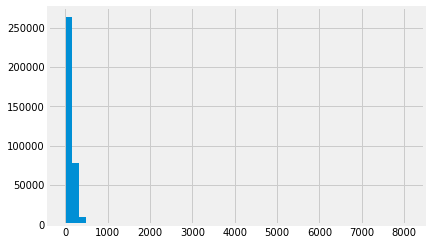

In [9]:
def count_words(text):
    return( len(text.split(" ") ) )

counts_ = []
for text in results:
    counts_.append(count_words(text) )

counts = np.array(counts_)

plt.hist(counts,bins=50)

In [10]:
def cutWords(text, lim):    
    tmp = text.split(" ")
    if len(tmp) < lim:
        lim = len(tmp)
    return( u" ".join( tmp[0:lim] ) )


texts_cut = []
for text in results:
    texts_cut.append(cutWords(text,300) )

# import matplotlib.pyplot as plt

# counts = np.array(counts_)
# plt.hist(counts,bins=50)

(array([ 2584., 29919., 73792., 78685., 60253., 38660., 23785., 14397.,
         8989., 20490.]),
 array([  1. ,  30.9,  60.8,  90.7, 120.6, 150.5, 180.4, 210.3, 240.2,
        270.1, 300. ]),
 <a list of 10 Patch objects>)

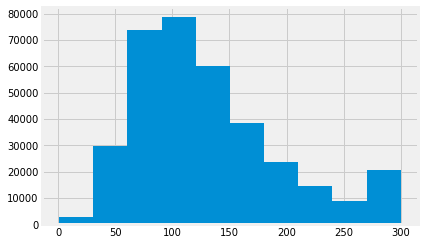

In [11]:

results_ = texts_cut

counts_ = []
for text in results_:
    counts_.append(count_words(text) )

import matplotlib.pyplot as plt

counts = np.array(counts_)
plt.hist(counts,bins=10)

In [12]:

texts = pd.Series(results_)

In [13]:
# from gensim.test.utils import common_texts, get_tmpfile
# from gensim.models import Word2Vec
# import gensim


# path = get_tmpfile("/opt/NLP_dev/models/word2vec/sbw_vectors.bin")
# word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

# data split

In [14]:
train_fraction = 0.7

np.random.seed(42)
train_indices = np.random.choice(labels.shape[0], round(train_fraction*labels.shape[0]), replace=False)
test_indices = np.array(list(set(range(labels.shape[0])) - set(train_indices)))

texts_ = texts

X_train0 = texts.iloc[train_indices]
y_train0 = labels.iloc[train_indices]

X_test0 = texts.iloc[test_indices]
y_test0 = labels.iloc[test_indices]

### Tokenizador keras 

In [15]:
NUM_WORDS=408400

tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

tokenizer.fit_on_texts(texts_)

sequences_train = tokenizer.texts_to_sequences(X_train0)
sequences_valid=tokenizer.texts_to_sequences(X_test0)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 408416 unique tokens.


In [16]:

X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
y_train = to_categorical(y_train0)
y_val = to_categorical(y_test0)
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)


Shape of X train and X validation tensor: (246088, 300) (105466, 300)
Shape of label train and validation tensor: (246088, 8) (105466, 8)


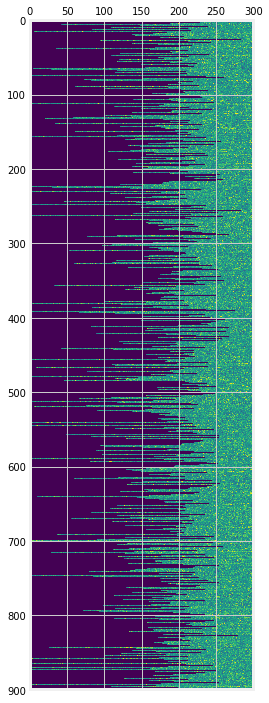

In [17]:
import matplotlib.pyplot as plt
plt.matshow(np.power(X_train[0:900],1/10))

### word embedding ###

https://github.com/uchile-nlp/spanish-word-embeddings

In [18]:
from gensim.models.keyedvectors import KeyedVectors

wordvectors_file_vec = "/opt/CNN_text_clas/models/wiki.fastext.es.vec"
word_vectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec)

#wordvectors_file_vec = "/opt/CNN_text_clas/models/SBW-word2vec-300-min5.bin"
#word_vectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
count_exist = 0
count_non_exist = 0

for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
        count_exist += 1

    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
        count_non_exist += 1

print("existen en vocabulario " + str(count_exist) )
print("No existen en vocabulario " + str(count_non_exist) )
        
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)

existen en vocabulario 208061
No existen en vocabulario 200338


In [50]:
word_vectors.most_similar_cosmul(positive=['pintor','mujer'],negative=['hombre'])


[('pintora', 1.0451276302337646),
 ('litógrafa', 0.9851875901222229),
 ('escultora', 0.9790560603141785),
 ('pintoras', 0.9449947476387024),
 ('pintoria', 0.9333548545837402),
 ('fotógrafa', 0.9158931970596313),
 ('escenógrafa', 0.9117776155471802),
 ('retratista', 0.9066284894943237),
 ('ceramista', 0.9065065979957581),
 ('pintors', 0.9040705561637878)]

In [58]:
word_vectors.most_similar_cosmul(positive=['rojo','mujer'],negative=['hombre'])


[('violeta', 0.8606666922569275),
 ('violetas', 0.8265278935432434),
 ('carmín', 0.8259550333023071),
 ('azul', 0.8198769092559814),
 ('rojo,', 0.8174360990524292),
 ('amarillo/blanco', 0.8059815168380737),
 ('anaranjada', 0.8012315034866333),
 ('amarillo/naranja', 0.7997034788131714),
 ('verde—', 0.7977133989334106),
 ('blanco', 0.79546719789505)]

In [54]:
word_vectors.most_similar_cosmul(positive=['habana','chile'],negative=['santiago'])


[('cuba', 0.9228107333183289),
 ('venezuela', 0.871705949306488),
 ('habana,cuba', 0.8631027936935425),
 ('habana,', 0.8540450930595398),
 ('venezuela,', 0.8496152758598328),
 ('venezuela―', 0.8459835648536682),
 ('–venezuela', 0.8436446785926819),
 ('habana»', 0.8430635333061218),
 ('cubana', 0.8374788761138916),
 ('cubanoamericana', 0.8368726968765259)]

# modelo

In [19]:

# sequence_length = X_train.shape[1]
# filter_sizes = [3,4,5]
# num_filters = 100
# drop = 0.5



# inputs = Input(shape=(sequence_length,))
# embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

# conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
# conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
# conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

# maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
# maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
# maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

# merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
# flatten = Flatten()(merged_tensor)
# reshape = Reshape((3*num_filters,))(flatten)
# dropout = Dropout(drop)(flatten)
# output = Dense(units=8, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# # this creates a model that includes
# model = Model(inputs, output)

In [20]:

sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100 # con 10 funciona bien con dataset chico, probar en grande
drop = 0.5



inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)


conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu'
         ,kernel_regularizer=regularizers.l2(0.001))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu'
         ,kernel_regularizer=regularizers.l2(0.001))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu'
         ,kernel_regularizer=regularizers.l2(0.001))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)


merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=8, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs, output)

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     122520000   input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 300, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 298, 1, 100)  90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
# inputs = Input(shape=(sequence_length,))

# embedded_sequences = embedding_layer(inputs)

# x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(35)(x)  # global max pooling
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# preds = Dense(8, activation='softmax')(x)

# model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])



### pesos , imbalance de clases

In [22]:
labelsSet = list(set(labels))
labelsSet.sort()
nClasses = len(labelsSet)

def calcWeights(y):
    sizes = {label: y_train0[y_train0 == label].shape[0] for label in labelsSet}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train0[y_train0 == label].shape[0] for label in labelsSet}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train0)*1

#weights_test = calcWeights(y_test0)

#weights_train

# from sklearn.utils import class_weight
# sample_weights = class_weight.compute_sample_weight('balanced', y_train)

print(weights_train)

[0.35863685 1.04793214 0.35863685 ... 0.35863685 1.00156286 1.04793214]


In [23]:
len(weights_train)

246088

In [24]:
# weights_sap = []
# for y in y_train0:
#     weights_sap.append(weights_train[y])

# weights_sap


# Callbacks

### confusion matrix

In [25]:

class ConfMat(Callback):
    def __init__(self, x, y_true, num_classes, X_val, y_val):
        super().__init__()
        
        self.x = x
        self.y_true = y_true
        self.num_classes = num_classes
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        
        y_pred=model.predict(self.x)        
        y_val_pred_hard = []    

        for idx,val in enumerate(y_pred):
            tmp = [0]*8
            tmp[np.argmax(val)] = 1
            y_val_pred_hard.append(tmp)    

        y_true = []
        y_pred = []

        for idx,val in enumerate(y_val_pred_hard):
            y_pred.append(np.argmax(val))

        for idx,val in enumerate(self.y_true):
            y_true.append(np.argmax(val))

        
        figc = plt.figure(figsize=(10,4),dpi=100)
        ax1c = figc.add_subplot(121)
        ax2c = figc.add_subplot(122)                    

        skplt.metrics.plot_confusion_matrix(y_true,y_pred,normalize='True',title = "entrenamiento",ax = ax1c, cmap = "Blues" )
        
        y_pred=model.predict(self.X_val)
        y_val_pred_hard = []    

        for idx,val in enumerate(y_pred):
            tmp = [0]*8
            tmp[np.argmax(val)] = 1
            y_val_pred_hard.append(tmp)    

        y_true = []
        y_pred = []

        for idx,val in enumerate(y_val_pred_hard):
            y_pred.append(np.argmax(val))

        for idx,val in enumerate(self.y_val):
            y_true.append(np.argmax(val))        
        
        skplt.metrics.plot_confusion_matrix(y_true,y_pred,normalize='True',title = "Validacion",ax = ax2c, cmap = "Reds")
        
        plt.show()
        
ConfMat_callback = ConfMat(X_train, y_train, 8, X_val, y_val)


In [26]:

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []        
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))        
        self.i += 1
        
        #clear_output(wait=True)
        
        fig = plt.figure(figsize=(10,4),dpi=90)

        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        #ax1.show();

        ax2.plot(self.x, self.acc, label="acc")
        ax2.plot(self.x, self.val_acc, label="val_acc")
        ax2.legend()
        #ax2.show();
        plt.show()
        
plot_losses = PlotLosses()

In [27]:
# callbacks

tensorboard = TensorBoard(log_dir="./logs/",
                          write_grads=True,
                          write_images=True,
                          histogram_freq=0,
                          embeddings_freq=0, 
                          embeddings_layer_names=["embedding_2"], 
                          embeddings_metadata=None, 
                          embeddings_data=None, 
                          update_freq='epoch')


#filepath="weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="weights/last_weights.hdf5"



checkpointer = ModelCheckpoint(filepath=filepath,
                               verbose=1,
                               save_best_only=True)


earlyStopping = EarlyStopping(monitor='val_loss' ,
                              patience=4,
                              restore_best_weights=False,
                              verbose=1)

# Train model

In [28]:
# from keras.models import load_model

# del model  # deletes the existing model

# model = load_model('weights/last_weights.hdf5')

Train on 246088 samples, validate on 105466 samples
Epoch 1/150
246088/246088 [==============================] - 686s 3ms/step - loss: 0.8018 - acc: 0.8312 - val_loss: 0.6600 - val_acc: 0.8696


<Figure size 432x288 with 0 Axes>

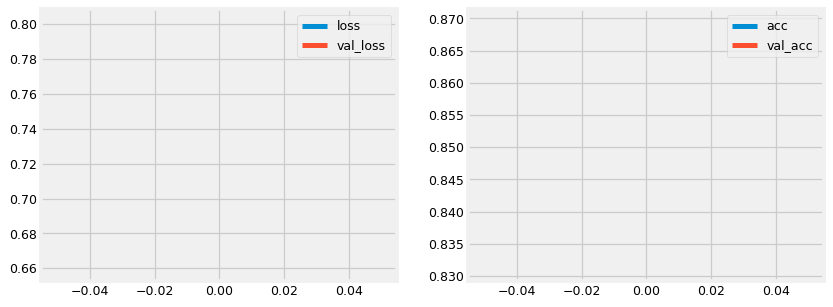

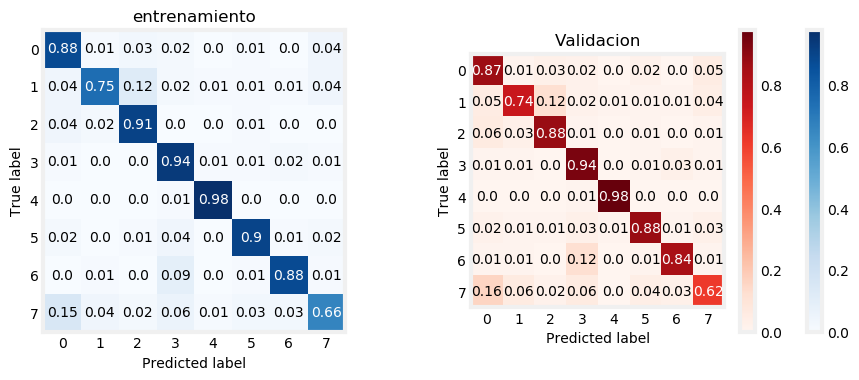


Epoch 00001: val_loss improved from inf to 0.66000, saving model to weights/last_weights.hdf5
Epoch 2/150
246088/246088 [==============================] - 685s 3ms/step - loss: 0.7886 - acc: 0.8581 - val_loss: 0.6328 - val_acc: 0.8918


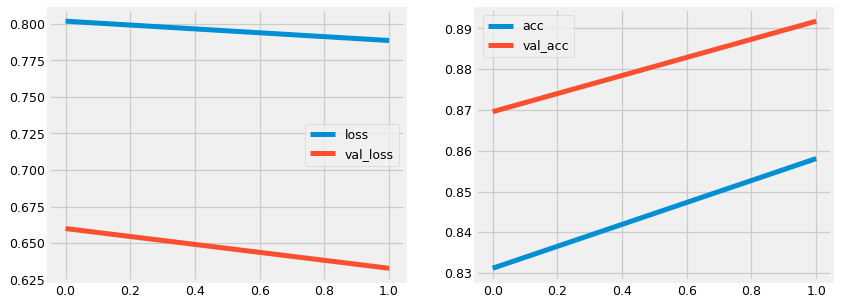

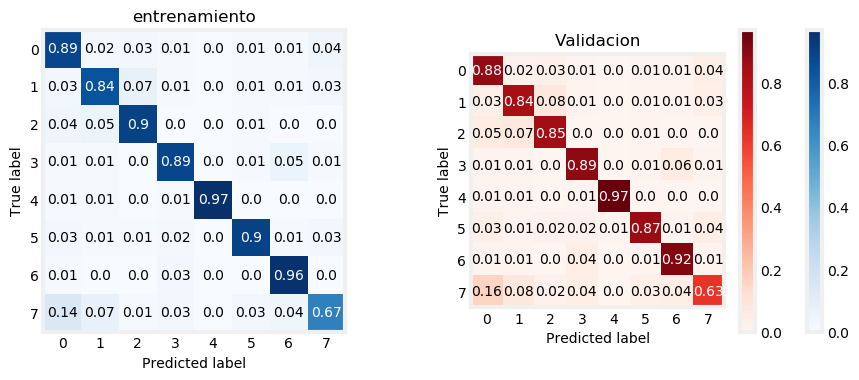


Epoch 00002: val_loss improved from 0.66000 to 0.63285, saving model to weights/last_weights.hdf5
Epoch 3/150
246088/246088 [==============================] - 685s 3ms/step - loss: 0.7849 - acc: 0.8622 - val_loss: 0.6862 - val_acc: 0.8774


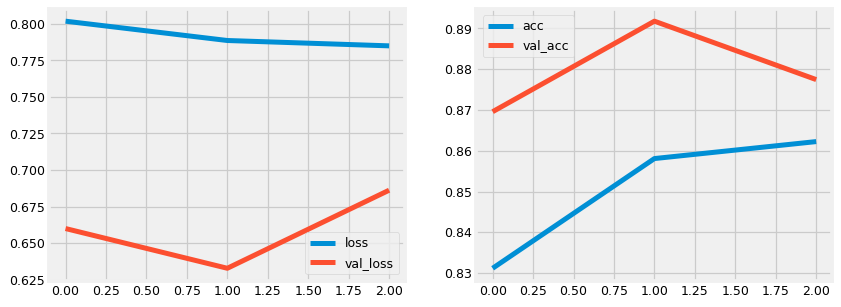

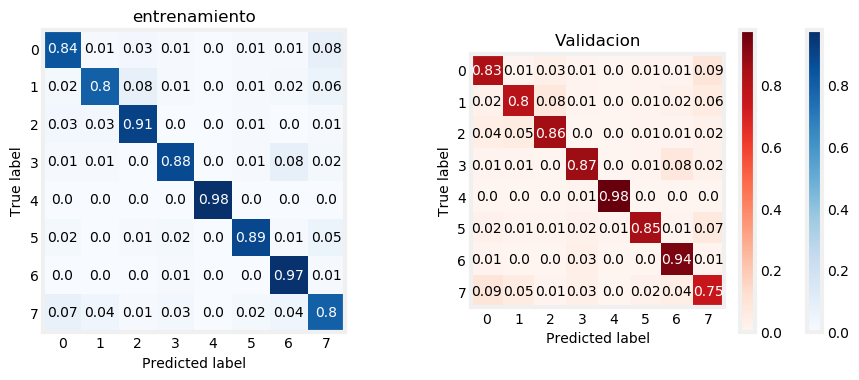


Epoch 00003: val_loss did not improve from 0.63285
Epoch 4/150
246088/246088 [==============================] - 693s 3ms/step - loss: 0.7831 - acc: 0.8659 - val_loss: 0.6698 - val_acc: 0.8871


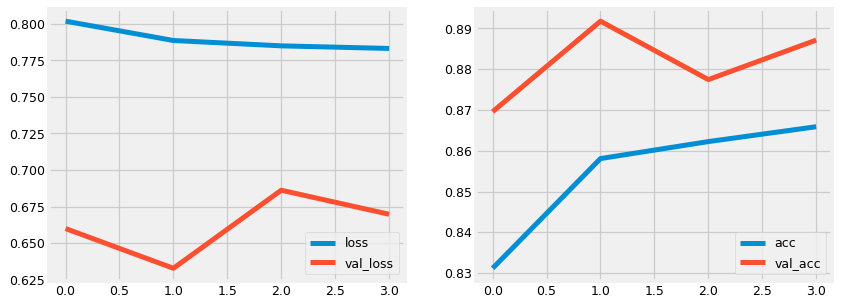

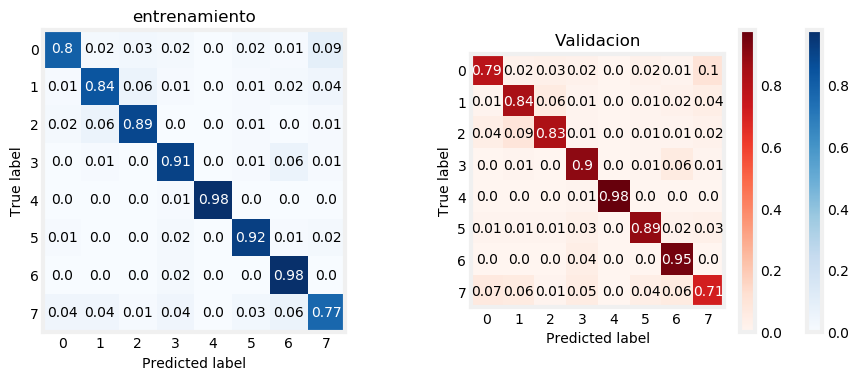


Epoch 00004: val_loss did not improve from 0.63285
Epoch 5/150
246088/246088 [==============================] - 694s 3ms/step - loss: 0.7782 - acc: 0.8669 - val_loss: 0.6363 - val_acc: 0.8896


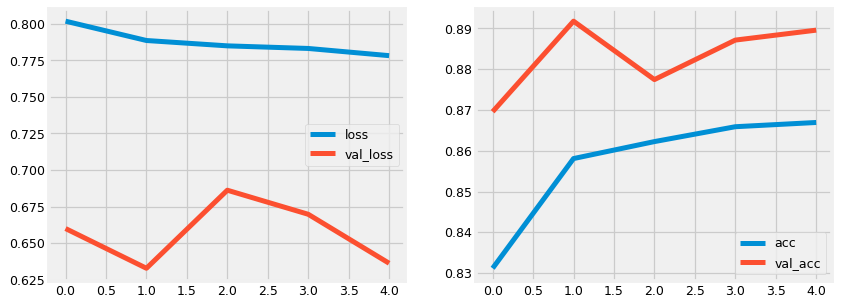

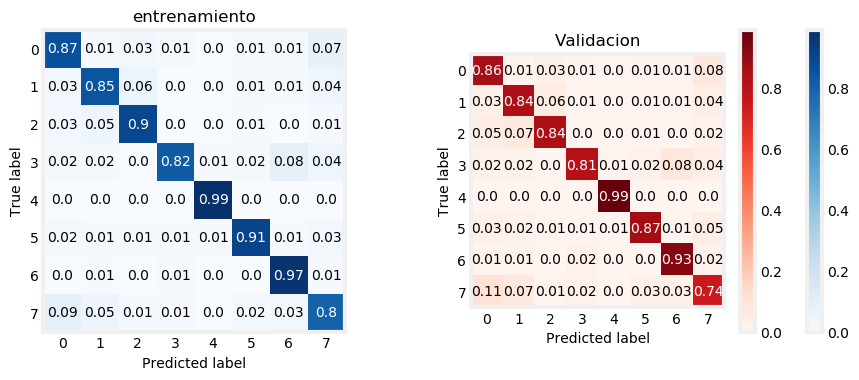


Epoch 00005: val_loss did not improve from 0.63285
Epoch 6/150
246088/246088 [==============================] - 693s 3ms/step - loss: 0.7736 - acc: 0.8679 - val_loss: 0.6370 - val_acc: 0.8945


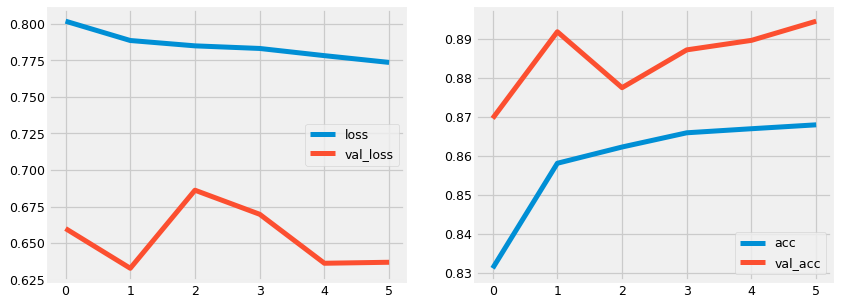

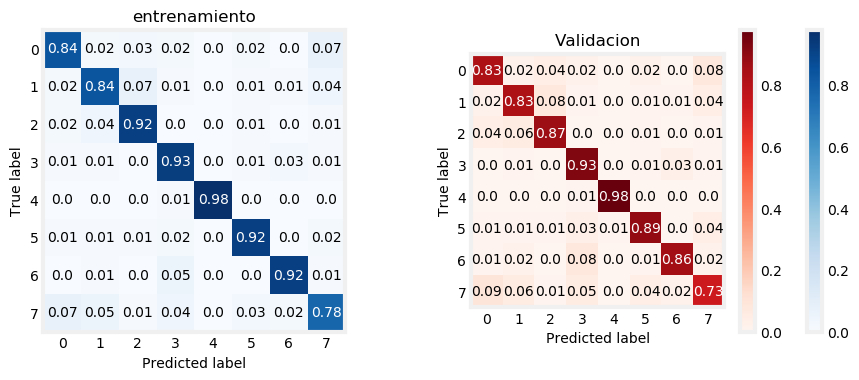


Epoch 00006: val_loss did not improve from 0.63285
Epoch 7/150
246088/246088 [==============================] - 691s 3ms/step - loss: 0.7688 - acc: 0.8680 - val_loss: 0.6697 - val_acc: 0.8814


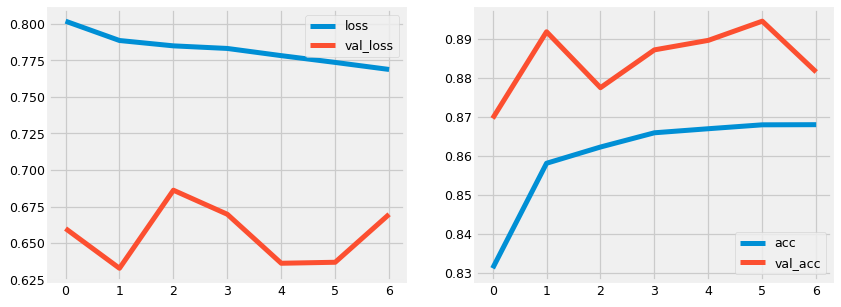

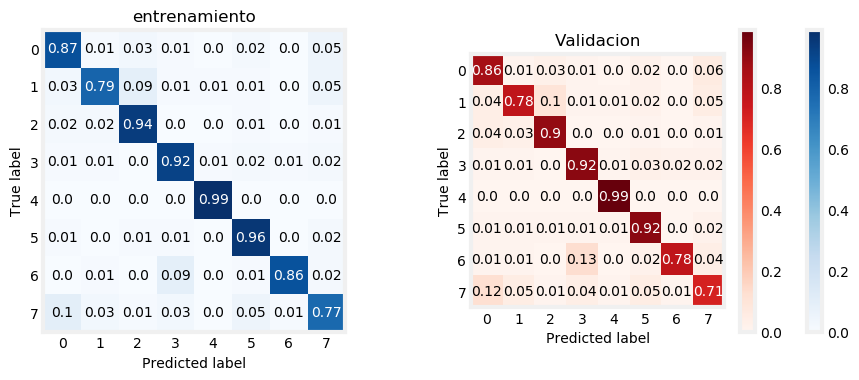


Epoch 00007: val_loss did not improve from 0.63285
Epoch 8/150
246088/246088 [==============================] - 688s 3ms/step - loss: 0.7754 - acc: 0.8688 - val_loss: 0.6008 - val_acc: 0.9021


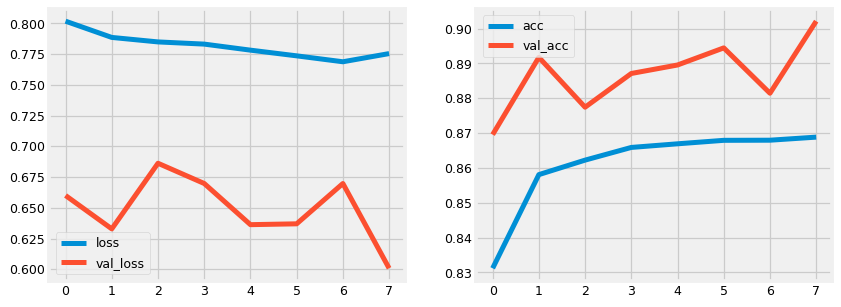

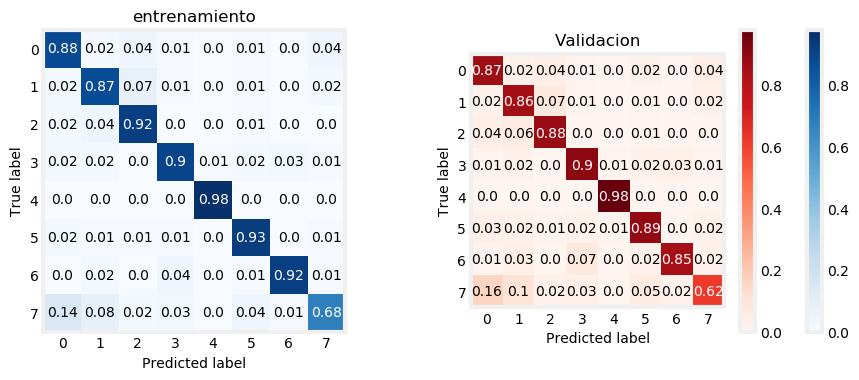


Epoch 00008: val_loss improved from 0.63285 to 0.60081, saving model to weights/last_weights.hdf5
Epoch 9/150
246088/246088 [==============================] - 687s 3ms/step - loss: 0.7658 - acc: 0.8693 - val_loss: 0.6207 - val_acc: 0.8963


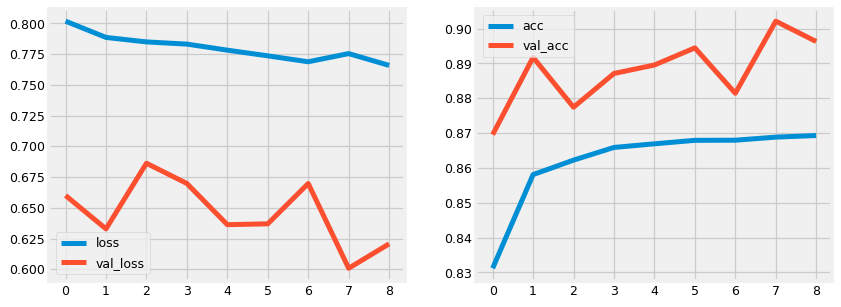

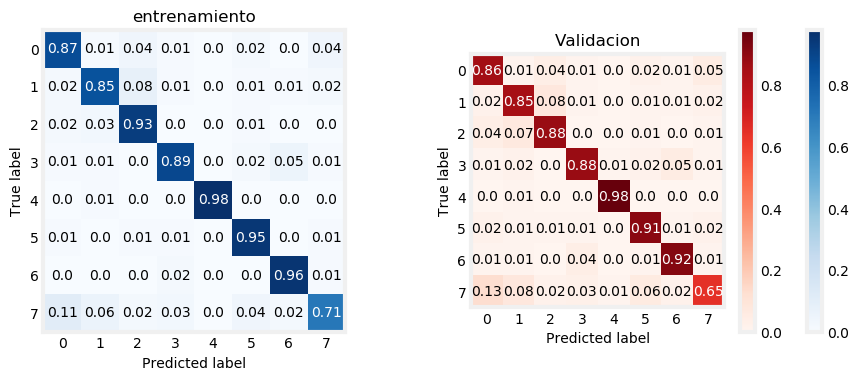


Epoch 00009: val_loss did not improve from 0.60081
Epoch 10/150
246088/246088 [==============================] - 695s 3ms/step - loss: 0.7628 - acc: 0.8703 - val_loss: 0.6101 - val_acc: 0.8985


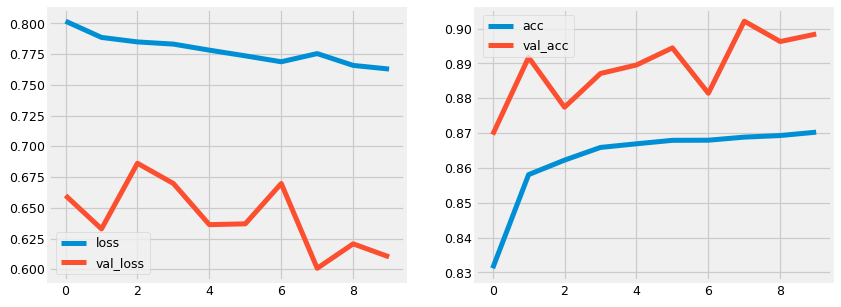

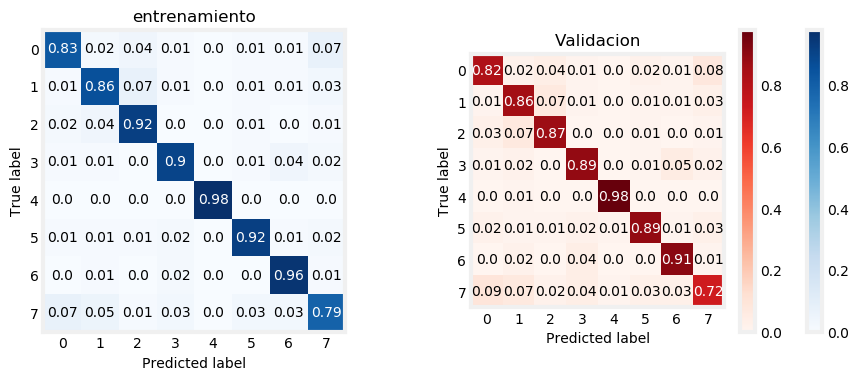


Epoch 00010: val_loss did not improve from 0.60081
Epoch 11/150
246088/246088 [==============================] - 694s 3ms/step - loss: 0.7612 - acc: 0.8710 - val_loss: 0.6030 - val_acc: 0.8997


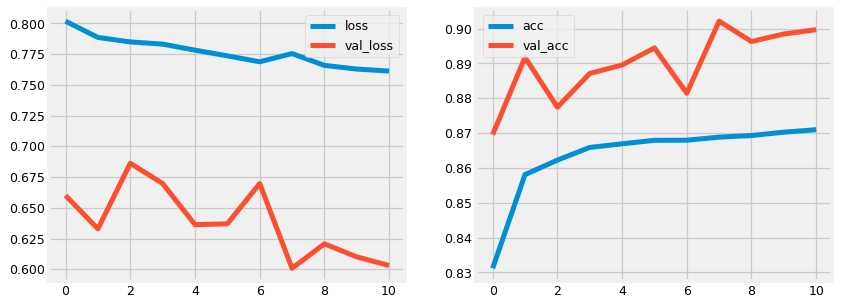

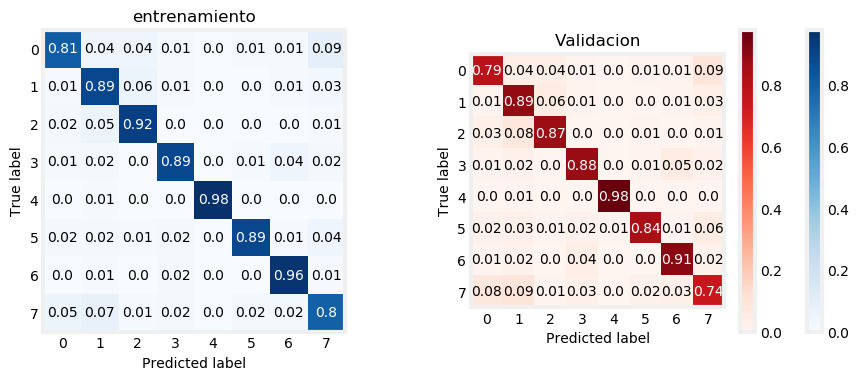


Epoch 00011: val_loss did not improve from 0.60081
Epoch 12/150
246088/246088 [==============================] - 705s 3ms/step - loss: 0.7562 - acc: 0.8709 - val_loss: 0.5826 - val_acc: 0.9074


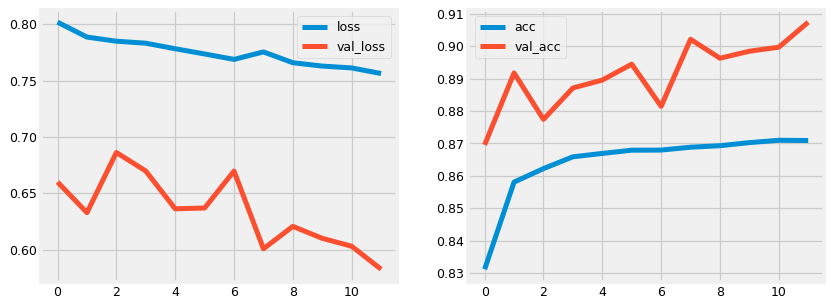

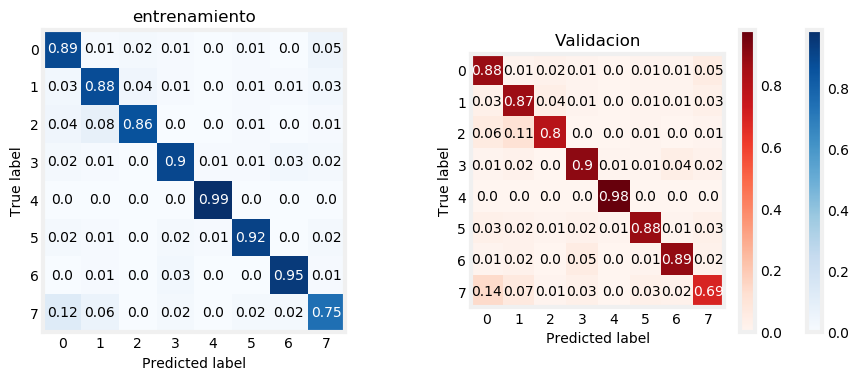


Epoch 00012: val_loss improved from 0.60081 to 0.58264, saving model to weights/last_weights.hdf5
Epoch 13/150
246088/246088 [==============================] - 704s 3ms/step - loss: 0.7520 - acc: 0.8717 - val_loss: 0.6062 - val_acc: 0.9000


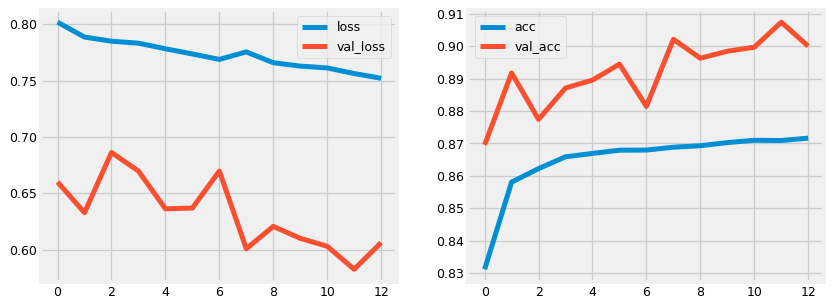

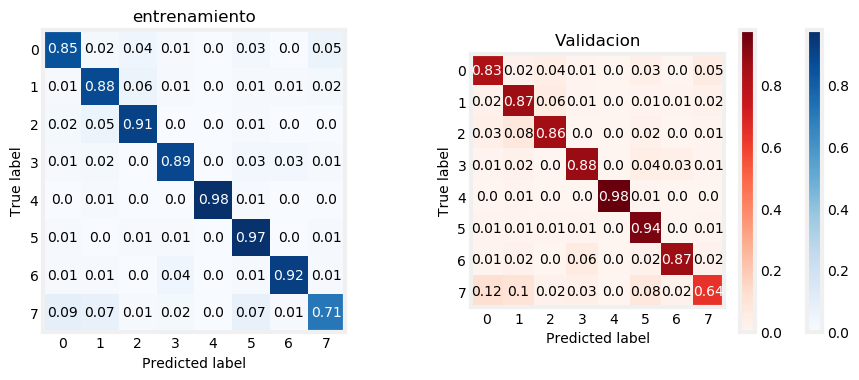


Epoch 00013: val_loss did not improve from 0.58264
Epoch 14/150
246088/246088 [==============================] - 698s 3ms/step - loss: 0.7481 - acc: 0.8711 - val_loss: 0.6061 - val_acc: 0.8936


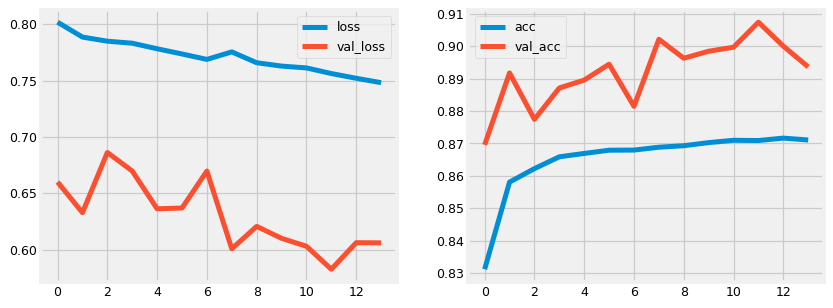

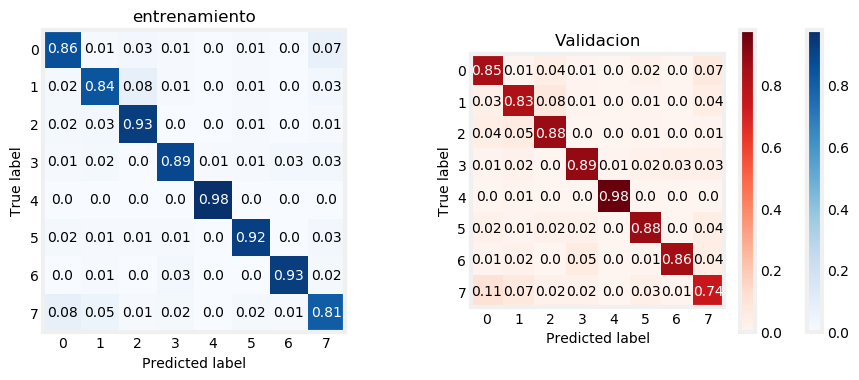


Epoch 00014: val_loss did not improve from 0.58264
Epoch 15/150
246088/246088 [==============================] - 688s 3ms/step - loss: 0.7425 - acc: 0.8717 - val_loss: 0.6603 - val_acc: 0.8800


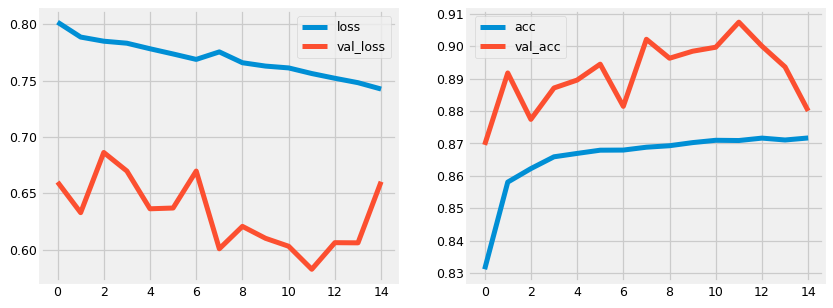

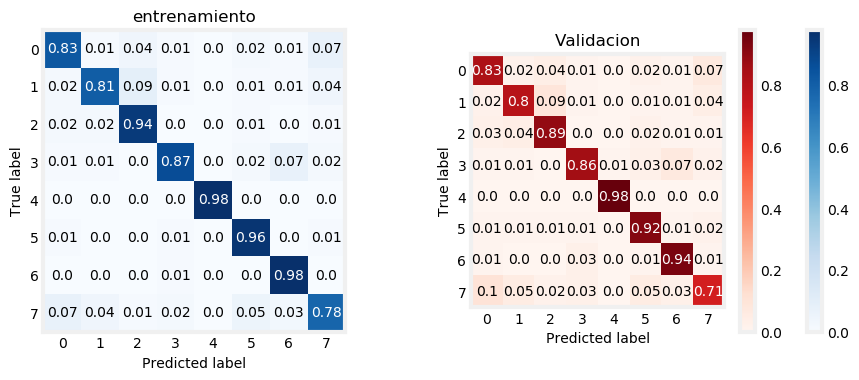


Epoch 00015: val_loss did not improve from 0.58264
Epoch 16/150
246088/246088 [==============================] - 700s 3ms/step - loss: 0.7434 - acc: 0.8710 - val_loss: 0.5945 - val_acc: 0.8988


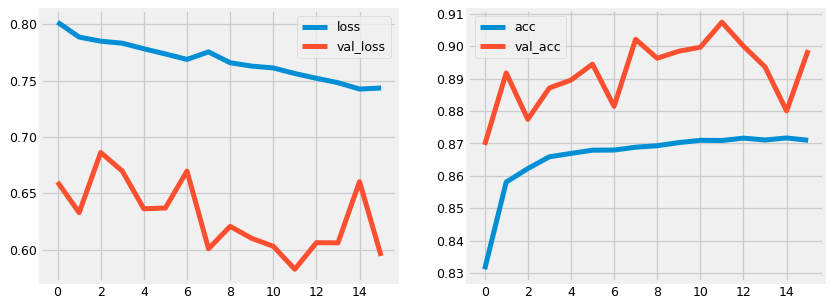

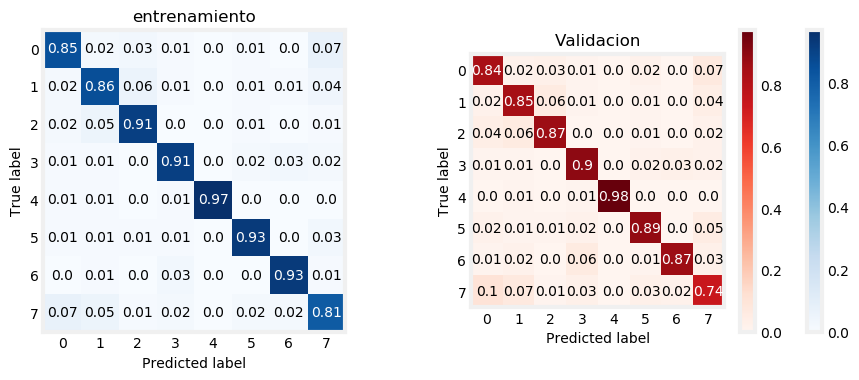


Epoch 00016: val_loss did not improve from 0.58264
Epoch 17/150
246088/246088 [==============================] - 696s 3ms/step - loss: 0.7424 - acc: 0.8712 - val_loss: 0.6067 - val_acc: 0.8945


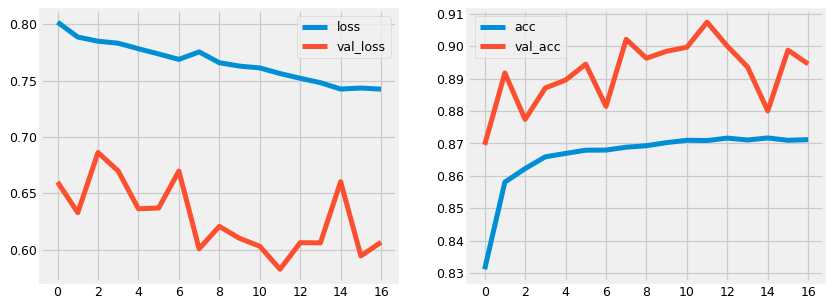

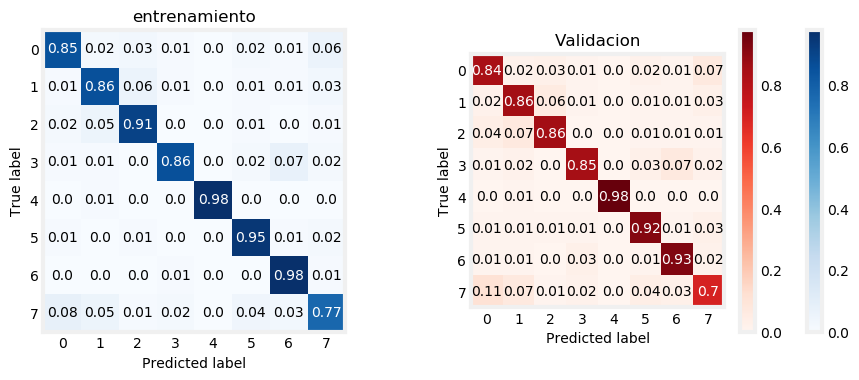


Epoch 00017: val_loss did not improve from 0.58264
Epoch 18/150
246088/246088 [==============================] - 690s 3ms/step - loss: 0.7338 - acc: 0.8713 - val_loss: 0.6279 - val_acc: 0.8892


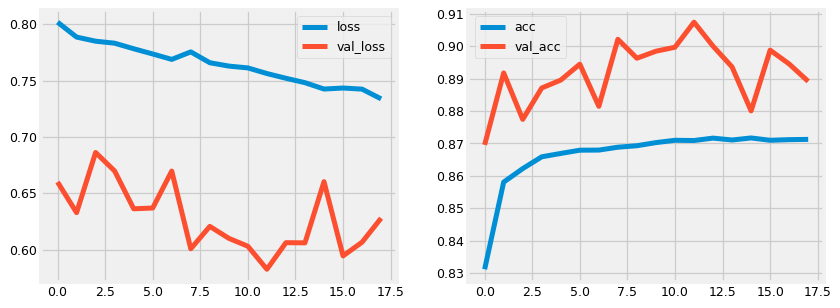

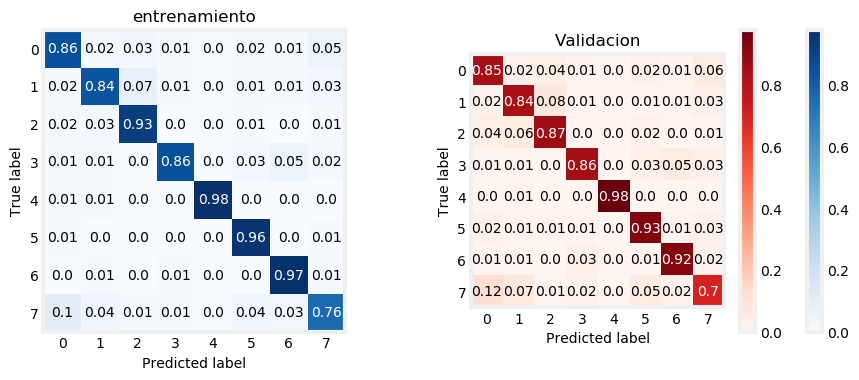


Epoch 00018: val_loss did not improve from 0.58264
Epoch 19/150
246088/246088 [==============================] - 697s 3ms/step - loss: 0.7302 - acc: 0.8720 - val_loss: 0.6049 - val_acc: 0.8960


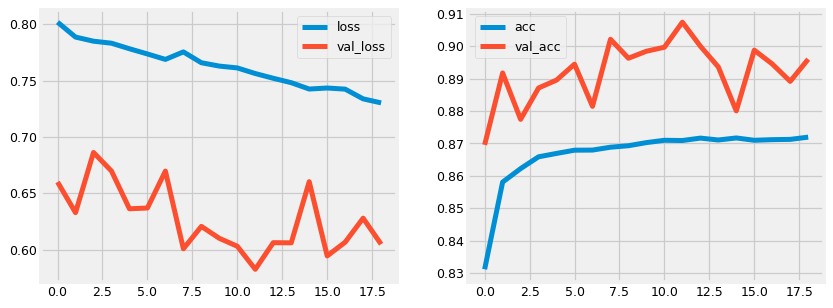

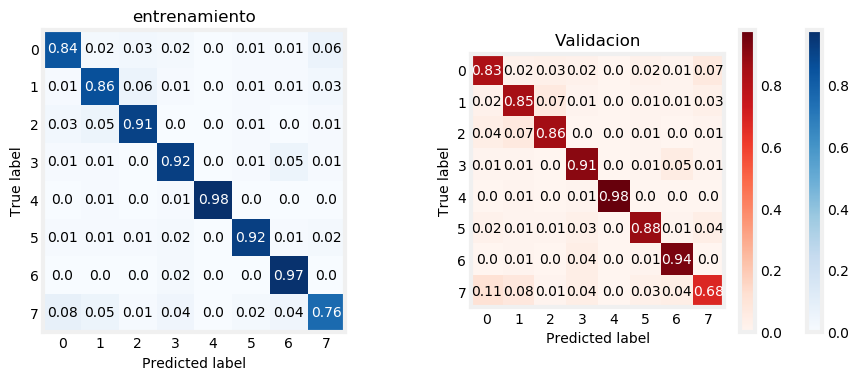


Epoch 00019: val_loss did not improve from 0.58264
Epoch 20/150
246088/246088 [==============================] - 693s 3ms/step - loss: 0.7286 - acc: 0.8710 - val_loss: 0.6782 - val_acc: 0.8738


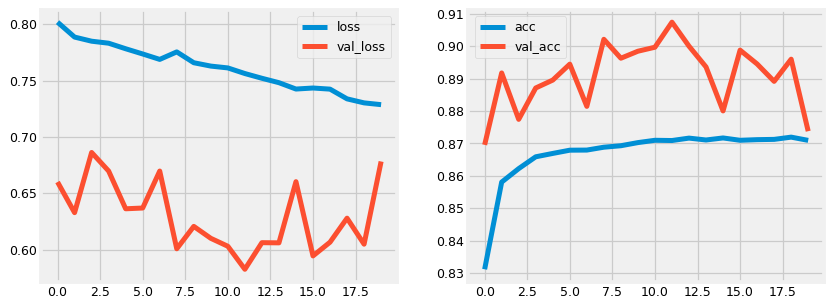

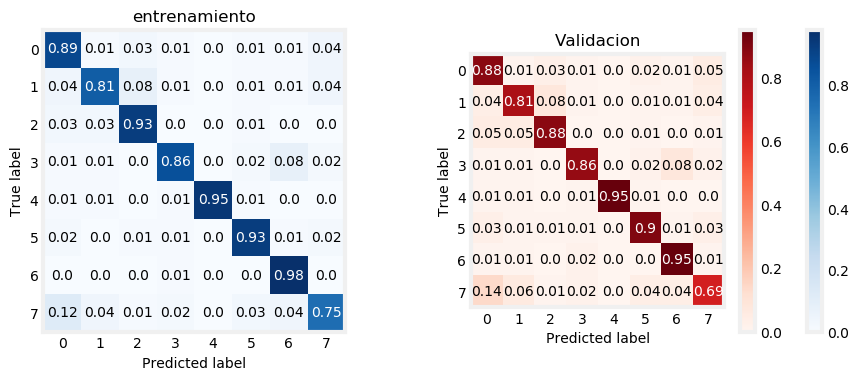


Epoch 00020: val_loss did not improve from 0.58264
Epoch 21/150
246088/246088 [==============================] - 692s 3ms/step - loss: 0.7295 - acc: 0.8709 - val_loss: 0.5948 - val_acc: 0.8951


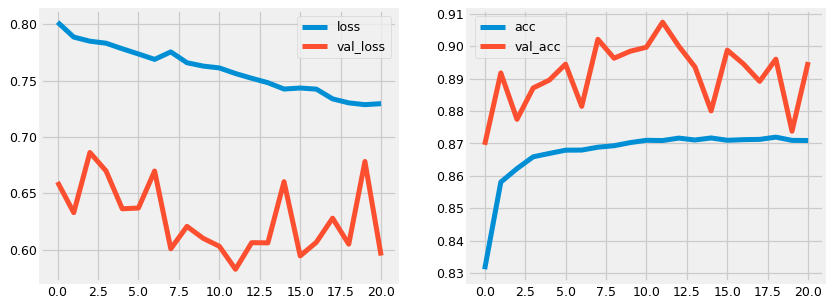

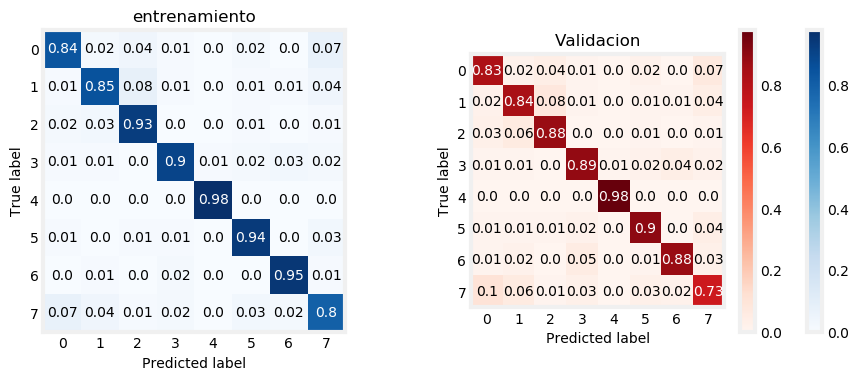


Epoch 00021: val_loss did not improve from 0.58264
Epoch 22/150
246088/246088 [==============================] - 692s 3ms/step - loss: 0.7260 - acc: 0.8725 - val_loss: 0.6003 - val_acc: 0.8935


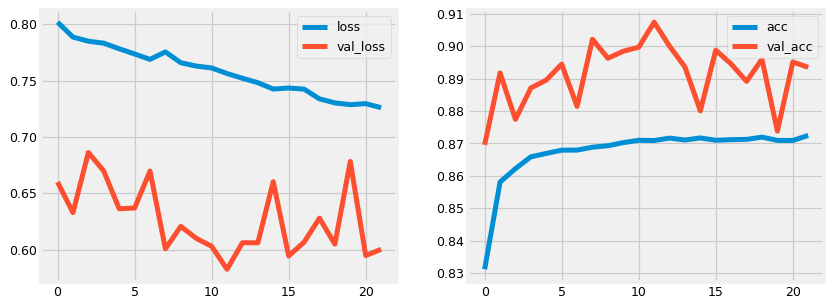

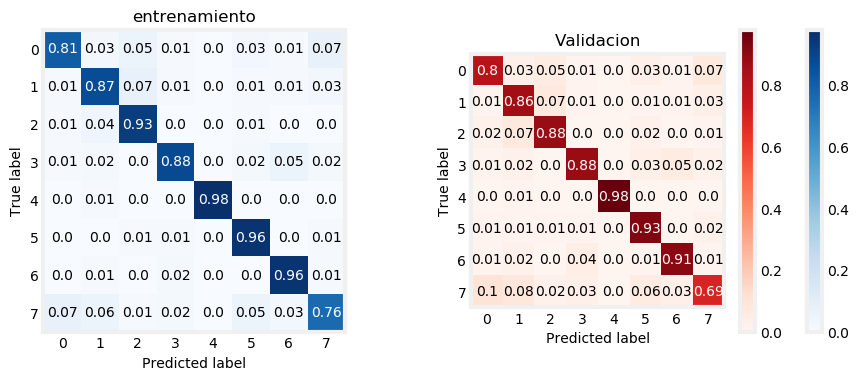


Epoch 00022: val_loss did not improve from 0.58264
Epoch 23/150
246088/246088 [==============================] - 685s 3ms/step - loss: 0.7282 - acc: 0.8713 - val_loss: 0.5788 - val_acc: 0.8972


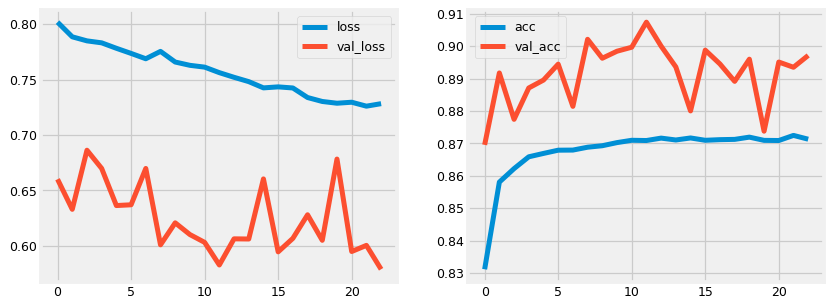

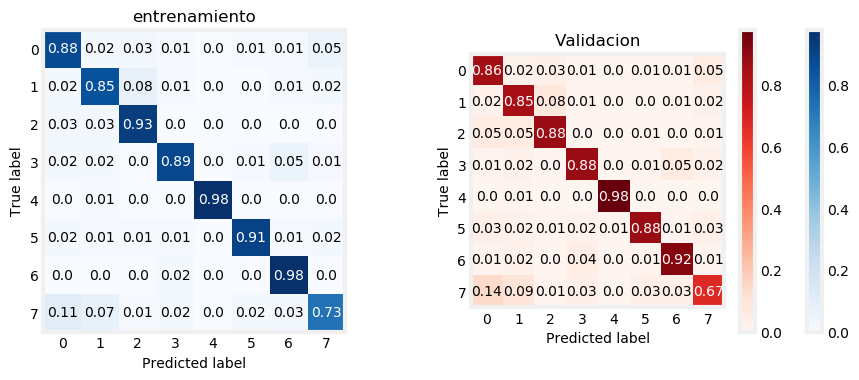


Epoch 00023: val_loss improved from 0.58264 to 0.57876, saving model to weights/last_weights.hdf5
Epoch 24/150
246088/246088 [==============================] - 681s 3ms/step - loss: 0.7213 - acc: 0.8724 - val_loss: 0.6516 - val_acc: 0.8766


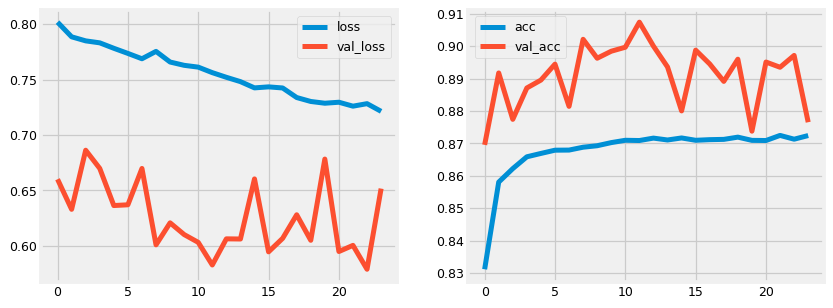

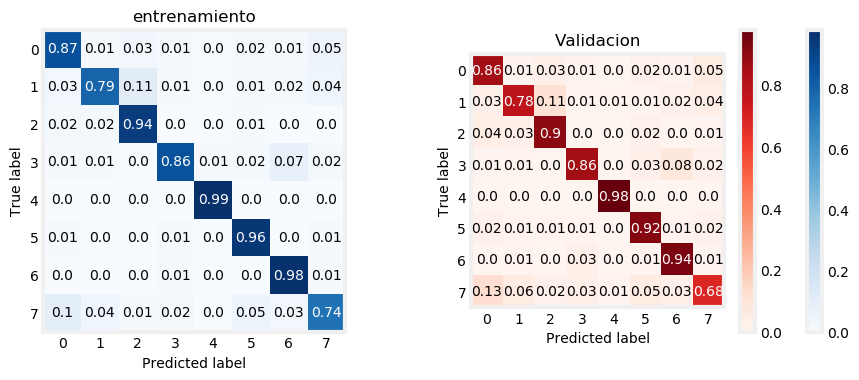


Epoch 00024: val_loss did not improve from 0.57876
Epoch 25/150
246088/246088 [==============================] - 692s 3ms/step - loss: 0.7272 - acc: 0.8715 - val_loss: 0.6241 - val_acc: 0.8832


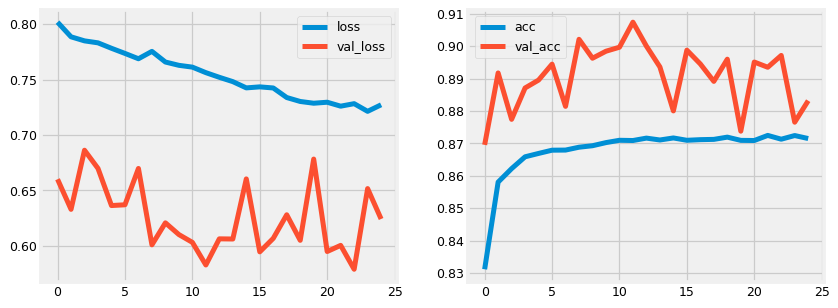

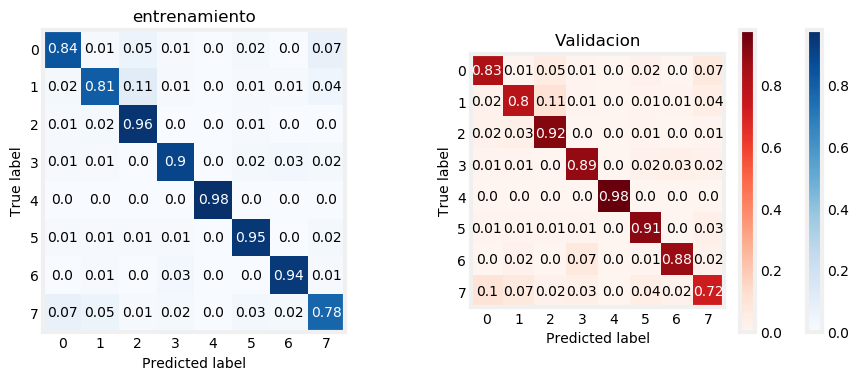


Epoch 00025: val_loss did not improve from 0.57876
Epoch 26/150
246088/246088 [==============================] - 679s 3ms/step - loss: 0.7156 - acc: 0.8720 - val_loss: 0.6092 - val_acc: 0.8870


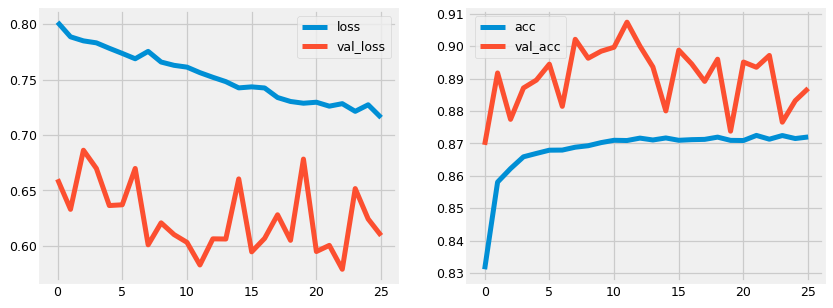

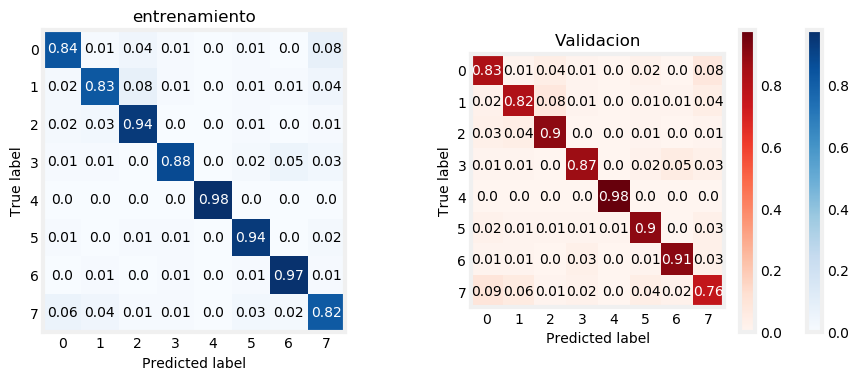


Epoch 00026: val_loss did not improve from 0.57876
Epoch 27/150
246088/246088 [==============================] - 685s 3ms/step - loss: 0.7201 - acc: 0.8719 - val_loss: 0.6034 - val_acc: 0.8899


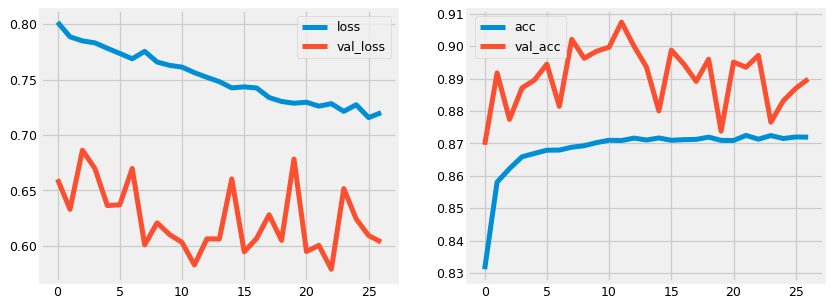

KeyboardInterrupt: 

In [29]:

#callbacks = [plot_losses,ConfMat_callback]
callbacks = [plot_losses,ConfMat_callback,checkpointer]
#callbacks = [earlyStopping,plot_losses,checkpointer, tensorboard,ConfMat_callback]
#callbacks = [earlyStopping,plot_losses, ConfMat_callback]

model.fit(X_train,
          y_train,
          batch_size=128, #512
          epochs=150,
          verbose=1,
          validation_data=(X_val, y_val),
          sample_weight = np.array(weights_train),
          #class_weight = weights_train,
          callbacks=callbacks) # starts training


# eval models

In [32]:
labelsSet

[0, 1, 2, 3, 4, 5, 6, 7]

In [33]:
secciones

array(['mundo', 'pais', 'economia', 'entretencion', 'deportes',
       'tecnologia', 'cultura', 'sociedad'], dtype=object)

In [34]:

y_pred=model.predict(X_val)

In [35]:
y_val_pred_hard = []


for idx,val in enumerate(y_pred):
    tmp = [0]*8
    tmp[np.argmax(val)] = 1
    y_val_pred_hard.append(tmp)    
    

y_true = []
y_pred = []

for idx,val in enumerate(y_val_pred_hard):
    y_pred.append(np.argmax(val))

for idx,val in enumerate(y_val):
    y_true.append(np.argmax(val))    


0.889888684504959


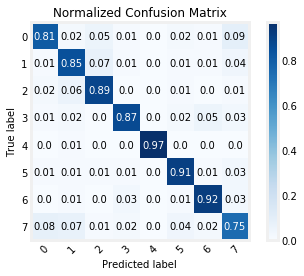

In [40]:
import scikitplot as skplt
import matplotlib.pyplot as plt

acc = accuracy_score(y_true=y_true, y_pred=y_pred)

a =skplt.metrics.plot_confusion_matrix( y_true,y_pred,normalize='True')
plt.xticks(rotation=45)

print(acc)


In [ ]:
cb = plt.colorbar
plt.show()